# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

**Цель проекта**

Вам нужно построить модель для определения стоимости. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

`/datasets/autos.csv`

Признаки:
- 'DateCrawled' — дата скачивания анкеты из базы
- 'VehicleType' — тип автомобильного кузова
- 'RegistrationYear' — год регистрации автомобиля
- 'Gearbox' — тип коробки передач
- 'Power' — мощность (л. с.)
- 'Model' — модель автомобиля
- 'Kilometer' — пробег (км)
- 'RegistrationMonth' — месяц регистрации автомобиля
- 'FuelType' — тип топлива
- 'Brand' — марка автомобиля
- 'NotRepaired' — была машина в ремонте или нет
- 'DateCreated' — дата создания анкеты
- 'NumberOfPictures' — количество фотографий автомобиля
- 'PostalCode' — почтовый индекс владельца анкеты (пользователя)
- 'LastSeen' — дата последней активности пользователя

Целевой признак:
- 'Price' — цена (евро)

In [1]:
# импорт библиотек

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
# отключу предупреждения
import warnings
warnings.filterwarnings('ignore')

`Примечания:`
- `Для оценки качества моделей применяйте метрику RMSE.`
- `Значение метрики RMSE должно быть меньше 2500.`
- `Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.`
- `Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.`
- `Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.`
- `Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.`

## Подготовка данных

### Обзор данных

In [3]:
#прочитаю датасет и ознакомлюсь с данными
try:
    data = pd.read_csv('datasets/autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [4]:
# получаю общую сводку
data.info()

# проверю на корректный вывод
display(data.sample(5))

# проверяю имена колонок на пробелы
display(data.columns)

# сводка по численным данным
data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
241148,2016-03-11 15:51:57,1200,wagon,1999,NaN,0,a4,150000,4,NaN,audi,no,2016-03-11 00:00:00,0,85540,2016-03-21 02:44:41
329447,2016-03-15 16:48:46,2900,wagon,2002,manual,163,a6,150000,11,gasoline,audi,no,2016-03-15 00:00:00,0,36088,2016-04-06 12:17:19
164506,2016-03-30 20:36:56,999,NaN,2016,manual,0,NaN,150000,0,NaN,fiat,yes,2016-03-30 00:00:00,0,66440,2016-03-30 20:36:56
90313,2016-03-08 17:56:49,4400,sedan,2006,auto,83,jazz,125000,6,petrol,honda,no,2016-03-08 00:00:00,0,14974,2016-03-09 17:45:03
169581,2016-04-03 16:49:58,11000,coupe,2009,auto,160,scirocco,125000,11,petrol,volkswagen,no,2016-04-03 00:00:00,0,6406,2016-04-05 16:46:00


Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [5]:
# проверю на явные дубликаты
'Количество явных дубликатов:', data.duplicated().sum()

('Количество явных дубликатов:', 4)

In [6]:
'Всего пропусков:', data.isna().sum()

('Всего пропусков:',
 DateCrawled              0
 Price                    0
 VehicleType          37490
 RegistrationYear         0
 Gearbox              19833
 Power                    0
 Model                19705
 Kilometer                0
 RegistrationMonth        0
 FuelType             32895
 Brand                    0
 NotRepaired          71154
 DateCreated              0
 NumberOfPictures         0
 PostalCode               0
 LastSeen                 0
 dtype: int64)

In [7]:
'Доля пропусков от общего количества строк:', data.isna().mean()

('Доля пропусков от общего количества строк:',
 DateCrawled          0.000000
 Price                0.000000
 VehicleType          0.105794
 RegistrationYear     0.000000
 Gearbox              0.055967
 Power                0.000000
 Model                0.055606
 Kilometer            0.000000
 RegistrationMonth    0.000000
 FuelType             0.092827
 Brand                0.000000
 NotRepaired          0.200791
 DateCreated          0.000000
 NumberOfPictures     0.000000
 PostalCode           0.000000
 LastSeen             0.000000
 dtype: float64)

In [8]:
# получу матрицу корреляции численных признаков
data_corr_matrix = data.corr().abs()
data_corr_matrix

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,0.000828,0.053447,0.011619,NaN,0.003459
Power,0.158872,0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,0.333199,0.053447,0.024002,1.000000,0.009571,NaN,0.007698
RegistrationMonth,0.110581,0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,0.003459,0.021665,0.007698,0.013995,NaN,1.000000


In [9]:
# избавлюсь от дублирующего треугольника
data_corr_matrix = data_corr_matrix.where(np.triu(np.ones(data_corr_matrix.shape), k=1).astype(np.bool))
data_corr_matrix

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,NaN,0.026916,0.158872,0.333199,0.110581,NaN,0.076055
RegistrationYear,NaN,NaN,0.000828,0.053447,0.011619,NaN,0.003459
Power,NaN,NaN,NaN,0.024002,0.043380,NaN,0.021665
Kilometer,NaN,NaN,NaN,NaN,0.009571,NaN,0.007698
RegistrationMonth,NaN,NaN,NaN,NaN,NaN,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# определю признаки с высокой корреляцией
[column for column in data_corr_matrix.columns if any(data_corr_matrix[column] > 0.90)]

[]

Пройдусь по уникальным значениям необходимых категориальных признаков.

In [11]:
data.VehicleType.value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [12]:
data.Gearbox.value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [13]:
data.Model.value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

Некоторые модели недостаточно представлены. Вероятно, в данной ситуации не требуется исправлений.

In [14]:
data.FuelType.value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [15]:
data.DateCrawled.max()

'2016-04-07 14:36:58'

Предварительные замечания:
- Признаки ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'] не требуются для обучения моделей;
- Названия признаков следует привести к нижнему регистру, для удобства работы;
- Пропуски в признаке ['VehicleType'], 10.58% от общего количества строк;
- Пропуски в признаке ['Gearbox'], 5.60% от общего количества строк;
- Пропуски в признаке ['Model'], 5.56% от общего количества строк;
- Пропуски в признаке ['FuelType'], 9.28% от общего количества строк;
- Пропуски в признаке ['NotRepaired'], 20.08% от общего количества строк;
- Обнаружено 4 явных дубликата;
- Не реалистичные минимальные и максимальные значения в признаках ['RegistrationYear', 'Power'] необходимых для обучения моделей;
- Года регистрации выше 2016 ошибочны;
- Нулевое минимальное занчение в ключевом признаке ['Price'].

In [16]:
data.Brand.value_counts()

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

In [17]:
data.NotRepaired.value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

### Предобработка данных

In [18]:
# избавлюсь от дубликатов 
data.drop_duplicates(inplace=True)

'Количество явных дубликатов:', data.duplicated().sum()

('Количество явных дубликатов:', 0)

In [19]:
# избавлюсь от ненужных признаков

data = data[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired']]

In [20]:
# получу список с названиями признаков и приведу их к snake_case

data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

In [21]:
data.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'not_repaired']

data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'not_repaired'],
      dtype='object')

Так как пропуски присутствуют исключительно в категориальных признаках, заполню их все категорией 'unknown'.

In [22]:
data.fillna('unknown', inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       354365 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            354365 non-null  object
 4   power              354365 non-null  int64 
 5   model              354365 non-null  object
 6   kilometer          354365 non-null  int64 
 7   fuel_type          354365 non-null  object
 8   brand              354365 non-null  object
 9   not_repaired       354365 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


Численные признаки 'registration_year', 'power', 'price' придется визуализировать.

Сначала избавлюсь от заведомо ошибочных нулевых значений стоимости а также невозможно низких значений стоимости. По данным по данным mobile.de на текущий момент количество предложений превышает 1000 только для цены от 500 евро. К сожалению для расчета инфляции я нашел только данные США.

"According to the U.S. Bureau of Labor Statistics, prices for used cars and trucks are 46.22% higher in 2022 versus 2016."

Поэтому установлю нижний предел стоимости автомобиля в 350 евро.

In [23]:
data = data.query('price >= 350')

<AxesSubplot:xlabel='price', ylabel='Count'>

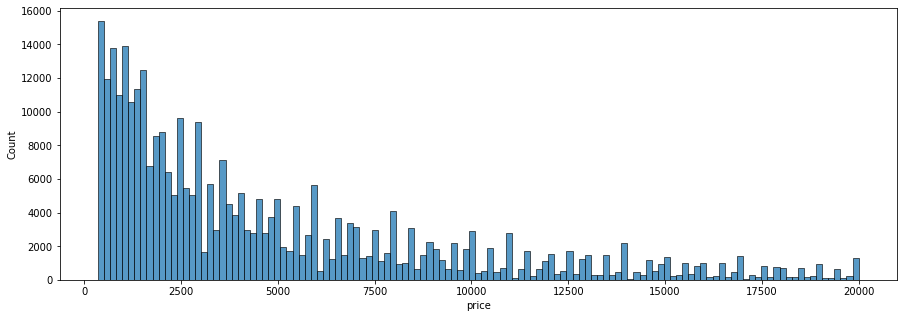

In [24]:
plt.figure(figsize= (15, 5))

sns.histplot(data['price'])

<AxesSubplot:xlabel='price'>

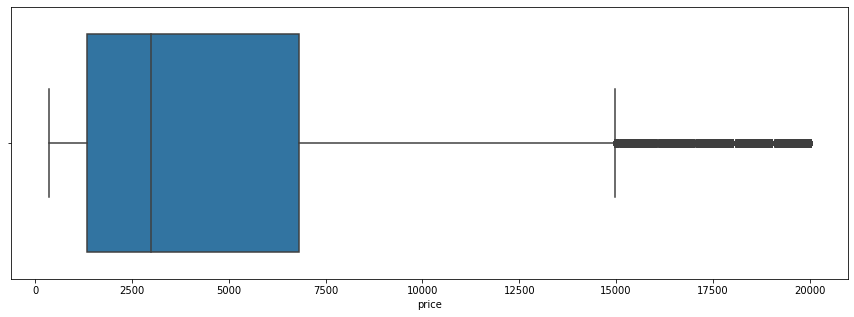

In [25]:
plt.figure(figsize= (15, 5))

sns.boxplot(data['price'])

Все автомобили стоимостью 15000 и выше это выброс. Избавлюсь от аномальных значений.

In [26]:
data = data.query('price < 15000')

С 'power' похожая ситуация. Имеются нулевые значения. Также Koenigsegg Regera являлся самым (либо одним из самых) мощных автомобилей на 2016 год, с мощность 1500 лошадиных сил. Заранее отсею все значения выше. Также отсею значения ниже 25 - лошадиные силы Austin A30.

In [27]:
data = data.query('power >= 25 and power < 1500')

<AxesSubplot:xlabel='power', ylabel='Count'>

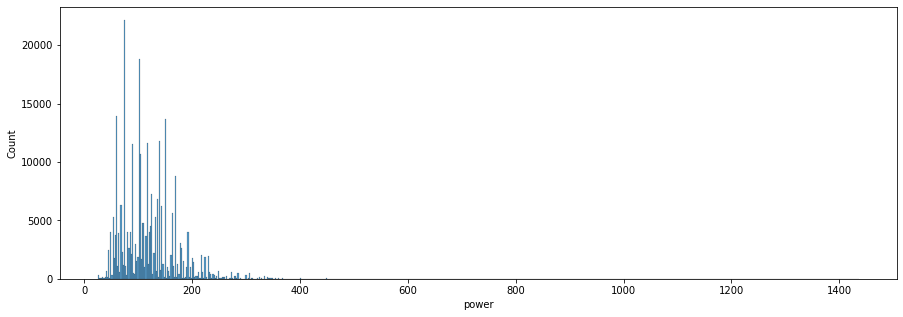

In [28]:
plt.figure(figsize= (15, 5))

sns.histplot(data['power'])

<AxesSubplot:xlabel='power'>

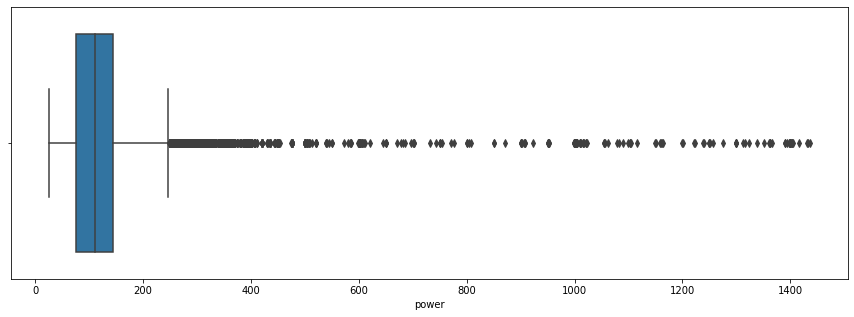

In [29]:
plt.figure(figsize= (15, 5))

sns.boxplot(data['power'])

Ограничусь 225 лошадиными силами.

In [30]:
data = data.query('power <= 225')

Осталось разобраться с признаком 'registration_year'. Изначально отсаю часть заведомо ложных значений для улучшения визуализации.

In [31]:
data = data.query('registration_year > 1900 and registration_year < 2017')

<AxesSubplot:xlabel='registration_year', ylabel='Count'>

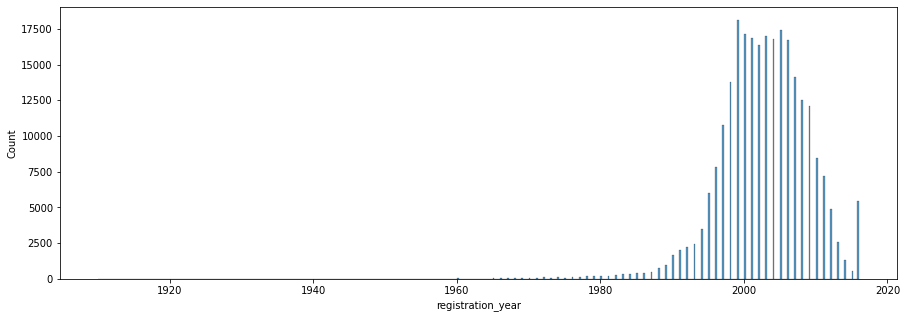

In [32]:
plt.figure(figsize= (15, 5))

sns.histplot(data['registration_year'])

<AxesSubplot:xlabel='registration_year'>

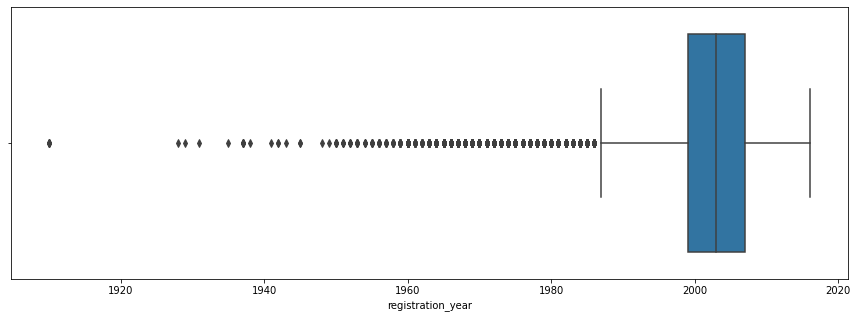

In [33]:
plt.figure(figsize= (15, 5))

sns.boxplot(data['registration_year'])

Ограничусь 1985 годом регистрации автомобиля.

In [34]:
data = data.query('registration_year >= 1985')

In [35]:
# интересно как изменилось количество явных дубликатов после очистки данных

'Количество явных дубликатов:', data.duplicated().sum()

('Количество явных дубликатов:', 35768)

In [36]:
# Очень много дубликатов! Синтетические данные? Сколько всего осталось строк?

data.shape

(258822, 10)

In [37]:
# Считаю правильным избавиться от дубликатов. Останется более чем достаточное количество данных для обучения.
# избегу риска переобучения на продублированных данных

data.drop_duplicates(inplace=True)

data.shape

(223054, 10)

### Вывод

По итогам обзора и подготовки данных:
Предварительные замечания:
- Отброшены признаки ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'];
- Названия признаков приведены к змеиному_регистру для удобства работы;
- Пропуски в категориальных признаках заменены значением 'unknown';
- Удалены строки с аномальными значениями в численных признаках ['registration_year', 'power', 'price'];
- Удалено значительное количество дубликатов образовавшихся после очистки данных.

In [38]:
#КОД РЕВЬЮЕРА

data.describe()

,price,registration_year,power,kilometer
count,223054.000000,223054.000000,223054.000000,223054.000000
mean,4226.988003,2003.046625,114.222188,128982.936867
std,3583.518669,5.659902,41.371514,35693.519504
min,350.000000,1985.000000,25.000000,5000.000000
25%,1400.000000,1999.000000,80.000000,125000.000000
50%,2999.000000,2003.000000,109.000000,150000.000000
75%,6199.000000,2007.000000,141.000000,150000.000000
max,14999.000000,2016.000000,225.000000,150000.000000


## Обучение моделей

In [39]:
# для фикасции результата воспользуюсь числом, полученным через генератор случайных чисел
STATE = 865154067

Дано задание использовать LightGBM модель и как минимум одну модель не использующую бустинг.
В данном проекте воспользуюсь моделями LGBMRegressor, CatBoostRegressor, LinearRegression и DecisionTreeRegressor.

Для обработки категориальных признаков использую технику прямого кодирования (One-hot Encoding), как наиболее универсальную.

In [40]:
target = data['price']
features = data.drop('price', axis=1)

In [41]:
# использую drop_first=True чтобы избежать дамми-ловушки
features_ohe = pd.get_dummies(features, drop_first=True)

In [42]:
# применю порядковое кодирование
encoder = OrdinalEncoder()

ordinal_list = ['vehicle_type','gearbox','model','fuel_type', 'brand', 'not_repaired']

ordinal_prep = features[ordinal_list]
ordinal_prep = pd.DataFrame(
    encoder.fit_transform(ordinal_prep),
    columns=ordinal_prep.columns, 
    index=ordinal_prep.index
)

ordinal_features = features

for column in ordinal_prep:
    ordinal_features[column] = ordinal_prep[column]

In [43]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=865154067)

In [44]:
ohe_features_train = features_ohe.loc[features_train.index, :]
ohe_features_test = features_ohe.loc[features_test.index, :]

ordinal_features_train = ordinal_features.loc[features_train.index, :]
ordinal_features_test = ordinal_features.loc[features_test.index, :]

In [45]:
# для линейной регрессии стандартизирую данные

scaler = StandardScaler().fit(ohe_features_train)
scaled_features_train = scaler.transform(ohe_features_train)
scaled_features_test = scaler.transform(ohe_features_test)

In [46]:
# выгружу ненужные данные
del data

### LGBMRegressor

In [47]:
%%time

# без гиперпараметров, обучение занимало какое-то совсем уж неадекватное время и безуспешно
# без гиперпараметров почти моментальное, интересно, разница колоссальная

model_lgbm = LGBMRegressor(random_state=STATE)

model_lgbm.fit(ohe_features_train, target_train)

CPU times: user 46.4 s, sys: 898 ms, total: 47.3 s
Wall time: 47.8 s


LGBMRegressor(random_state=865154067)

In [48]:
nrmse_lgbm = cross_val_score(model_lgbm, ohe_features_train, target_train, cv=5, scoring='neg_root_mean_squared_error')

print(nrmse_lgbm)
print('Значение RMSE для LGBMRegressor:', -nrmse_lgbm.mean())

[-1348.11686163 -1358.91500682 -1348.06681444 -1351.9956033
 -1337.78586637]
Значение RMSE для LGBMRegressor: 1348.9760305114853


### CatBoostRegressor

In [49]:
%%time

# то же самое

model_cb = CatBoostRegressor(random_state=STATE)

model_cb.fit(ohe_features_train, target_train)

Learning rate set to 0.091936
0:	learn: 3373.3127586	total: 74ms	remaining: 1m 13s
1:	learn: 3189.1047335	total: 103ms	remaining: 51.4s
2:	learn: 3019.3699633	total: 126ms	remaining: 41.8s
3:	learn: 2871.5428411	total: 150ms	remaining: 37.2s
4:	learn: 2741.0903154	total: 170ms	remaining: 33.8s
5:	learn: 2623.7361378	total: 197ms	remaining: 32.6s
6:	learn: 2520.0254911	total: 220ms	remaining: 31.2s
7:	learn: 2425.0612916	total: 241ms	remaining: 29.8s
8:	learn: 2338.9700702	total: 263ms	remaining: 29s
9:	learn: 2263.1268301	total: 292ms	remaining: 28.9s
10:	learn: 2198.7873948	total: 318ms	remaining: 28.6s
11:	learn: 2144.4792242	total: 342ms	remaining: 28.1s
12:	learn: 2091.7683983	total: 369ms	remaining: 28s
13:	learn: 2046.5559216	total: 389ms	remaining: 27.4s
14:	learn: 2006.7179543	total: 410ms	remaining: 26.9s
15:	learn: 1971.0802255	total: 430ms	remaining: 26.5s
16:	learn: 1937.5271116	total: 451ms	remaining: 26.1s
17:	learn: 1907.7116980	total: 472ms	remaining: 25.7s
18:	learn: 1

In [50]:
nrmse_cb = cross_val_score(model_cb, ohe_features_train, target_train, cv=5, scoring='neg_root_mean_squared_error')

print(nrmse_cb)
print('Значение RMSE для CatBoostRegressor:', -nrmse_cb.mean())

Learning rate set to 0.088752
0:	learn: 3392.8225061	total: 25.2ms	remaining: 25.2s
1:	learn: 3211.2956081	total: 45.5ms	remaining: 22.7s
2:	learn: 3051.1488414	total: 68.4ms	remaining: 22.7s
3:	learn: 2900.5116201	total: 85.7ms	remaining: 21.4s
4:	learn: 2767.6454873	total: 103ms	remaining: 20.4s
5:	learn: 2653.7621077	total: 119ms	remaining: 19.8s
6:	learn: 2547.0020981	total: 136ms	remaining: 19.3s
7:	learn: 2455.6931764	total: 161ms	remaining: 20s
8:	learn: 2371.6762319	total: 177ms	remaining: 19.5s
9:	learn: 2295.0868105	total: 196ms	remaining: 19.4s
10:	learn: 2226.6084986	total: 216ms	remaining: 19.4s
11:	learn: 2167.8542147	total: 243ms	remaining: 20s
12:	learn: 2116.8963434	total: 263ms	remaining: 19.9s
13:	learn: 2069.6914970	total: 279ms	remaining: 19.6s
14:	learn: 2025.5683322	total: 295ms	remaining: 19.4s
15:	learn: 1987.3681266	total: 311ms	remaining: 19.1s
16:	learn: 1953.8447021	total: 326ms	remaining: 18.9s
17:	learn: 1923.3027241	total: 351ms	remaining: 19.2s
18:	lear

### LinearRegression

In [51]:
%%time

model_lr = LinearRegression()

model_lr.fit(ohe_features_train, target_train)

CPU times: user 10.6 s, sys: 6.36 s, total: 16.9 s
Wall time: 17 s


LinearRegression()

In [52]:
nrmse_lr = cross_val_score(model_lr, ohe_features_train, target_train, cv=5, scoring='neg_root_mean_squared_error')

print(nrmse_lr)
print('Значение RMSE для Линейной Регрессии:', -nrmse_lr.mean())

[-1922.38601263 -1943.49163031 -1941.42236603 -1945.06666131
 -1904.65673023]
Значение RMSE для Линейной Регрессии: 1931.4046801037755


### DecisionTreeRegressor

In [53]:
%%time

dtr = DecisionTreeRegressor()

params_tree = [{
    'max_depth': range(2, 6),
    'random_state':[STATE]
}]

model_tree = GridSearchCV(dtr,
                      param_grid=params_tree,
                      scoring='neg_root_mean_squared_error')

model_tree.fit(ordinal_features_train, target_train)

CPU times: user 2.36 s, sys: 34.6 ms, total: 2.4 s
Wall time: 2.43 s


GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': range(2, 6),
                          'random_state': [865154067]}],
             scoring='neg_root_mean_squared_error')

In [54]:
print('Лучшее значение RMSE для Дерева Решений:', -model_tree.best_score_)
'Оптимальные параметры модели:', model_tree.best_params_

Лучшее значение RMSE для Дерева Решений: 1981.9261024444986


('Оптимальные параметры модели:', {'max_depth': 5, 'random_state': 865154067})

## Анализ моделей

Все модели прошли по значению метрики RMSE по результату кросс-валидации.

Время обучения LGBMRegressor, CatBoostRegressor и LinearRegression известно. Следует получить время обучения DecisionTreeRegressor с определенными гиперпараметрами.

In [55]:
%%time

# найду время обучения DecisionTreeRegressor

model_tree = DecisionTreeRegressor(max_depth=5, random_state=STATE)

model_tree.fit(ordinal_features_train, target_train)

CPU times: user 171 ms, sys: 0 ns, total: 171 ms
Wall time: 180 ms


DecisionTreeRegressor(max_depth=5, random_state=865154067)

Определю время предсказания и финальный RMSE на текстовой выборке для каждой из моделей.

### LGBMRegressor

In [56]:
%%time

# найду время предсказания используя те же тренировочные данные

lgbm_predict = model_lgbm.predict(ohe_features_train)

CPU times: user 1.79 s, sys: 231 ms, total: 2.02 s
Wall time: 1.99 s


### CatBoostRegressor

In [57]:
%%time

cb_predict = model_cb.predict(ohe_features_train)

CPU times: user 299 ms, sys: 0 ns, total: 299 ms
Wall time: 364 ms


### LinearRegression

In [63]:
%%time

lr_predict = model_lr.predict(ohe_features_train)

CPU times: user 250 ms, sys: 257 ms, total: 506 ms
Wall time: 463 ms


### DecisionTreeRegressor

In [64]:
%%time

dtr_predict = model_tree.predict(ordinal_features_train)

CPU times: user 10.1 ms, sys: 4.26 ms, total: 14.4 ms
Wall time: 12.6 ms


### Сравнение моделей

Определю наилучшую модель в каждой из категорий:
- Время обучения без подбора гиперпараметров;
- Время прогнозирования на тренировочной выборке;
- Наименьшая RMSE по результатам кросс-валидации.

In [65]:
# сегодня время обучения LGBM сильно повысилось. Любопытно.

comparison = {
    'LGBMRegressor':[47.8, 2.0, 1349],
    'CatBoostRegressor':[24.0, 0.4, 1290],
    'LinearRegression':[17, 0.5, 1931],
    'DecisionTreeRegressor':[0.2, 0.01, 1982]
                }

comparison = pd.DataFrame(data=comparison, index=['learning_time', 'prediction_time', 'RMSE'])

comparison

,LGBMRegressor,CatBoostRegressor,LinearRegression,DecisionTreeRegressor
learning_time,47.8,24.0,17.0,0.20
prediction_time,2.0,0.4,0.5,0.01
RMSE,1349.0,1290.0,1931.0,1982.00


Время обучения по мере увеличения:
1) DecisionTreeRegressor;  
2) LinearRegressor;  
3) LGBMRegressor;  
4) CatBoostRegressor.

Время прогнозирования по мере увеличения:
1) DecisionTreeRegressor;  
2) CatBoostRegressor;  
3) LinearRegressor;  
4) LGBMRegressor.

RMSE по мере увеличения:
1) CatBoostRegressor;  
2) LGBMRegressor;  
3) LinearRegressor;  
4) DecisionTreeRegressor.

Определим две лидирующие модели по совокупности критериев найдя суммарный рейтинг, где 1 это наилучший результат - лидирующая величина разделеная на себя, а остальные - лидирующая величина разделеная на текущую величину.

In [66]:
comparison = comparison.T
comparison

,learning_time,prediction_time,RMSE
LGBMRegressor,47.8,2.00,1349.0
CatBoostRegressor,24.0,0.40,1290.0
LinearRegression,17.0,0.50,1931.0
DecisionTreeRegressor,0.2,0.01,1982.0


In [67]:
comparison['learning_rate'] = comparison['learning_time'].min() / comparison['learning_time']
comparison['prediction_rate'] = comparison['prediction_time'].min() / comparison['prediction_time']
comparison['RMSE_rate'] = comparison['RMSE'].min() / comparison['RMSE']
comparison['total_rate'] = comparison['learning_rate'] + comparison['prediction_rate'] + comparison['RMSE_rate']
comparison

,learning_time,prediction_time,RMSE,learning_rate,prediction_rate,RMSE_rate,total_rate
LGBMRegressor,47.8,2.00,1349.0,0.004184,0.005,0.956264,0.965448
CatBoostRegressor,24.0,0.40,1290.0,0.008333,0.025,1.000000,1.033333
LinearRegression,17.0,0.50,1931.0,0.011765,0.020,0.668048,0.699812
DecisionTreeRegressor,0.2,0.01,1982.0,1.000000,1.000,0.650858,2.650858


Сравню две лидирующие модели DecisionTreeRegressor и CatBoostRegressor путем получения прогноза на тестовой выборке и сравнения RMSE без кросс-валидации.

In [72]:
%%time

dtr_predict = model_tree.predict(ordinal_features_test)
dtr_RMSE = mean_squared_error(target_test, dtr_predict) ** 0.5
dtr_RMSE

CPU times: user 6.81 ms, sys: 244 µs, total: 7.05 ms
Wall time: 5.96 ms


1965.431003990031

In [73]:
%%time

cb_predict = model_cb.predict(ohe_features_test)
cb_RMSE = mean_squared_error(target_test, cb_predict) ** 0.5
cb_RMSE

CPU times: user 110 ms, sys: 0 ns, total: 110 ms
Wall time: 108 ms


1272.37779693875

### Общий вывод

Была дана задача обучения и сравнения моделей прогнозирующих стоимость подержанных автомобилей.  
Для проекта использовано LGBMRegressor, CatBoostRegressor, LinearRegression и DecisionTreeRegressor.  
В качестве требования к моделям требовалось достижение метрики RMSE ниже 2500, что успешно достигнуто всеми из использованных моделей.  

Качество моделей для заказчика определяется по следующим параметрам:
- качество предсказания;
- скорость предсказания;
- время обучения.

По итогам анализа определено что по совокупности параметров лидирует модель DecisionTreeRegressor, за счет наибольшей скорости обучения и прогнозирования, но эта модель показала наименьший RMSE, все еще в пределах 2500.  По итоговой проверке на тестовых данных RMSE значительно не отличается от полученого в ходу кросс-валидации на тренировочной выборке (1965 против 1982). 

На втором месте по совокупности параметров находится модель CatBoostRegressor, показавшая налучшее значение RMSE и второе место по времени прогнозирования, но худшее время обучения. По итоговой проверке на тестовых данных RMSE значительно не отличается от полученого в ходу кросс-валидации на тренировочной выборке (1272 против 1290).  

В зависимости от важности показателя RMSE можно рекомендовать заказчику рассмотреть возможность использования CatBoostRegressor. При прогнозировании на тестовой выборке модель DecisionTreeRegressor отработала в 18 раз быстрее чем модель CatBoostRegressor.